In [29]:
# Para no tener que reiniciar el kernel
%load_ext autoreload
%autoreload 2

# Tratamiento de datos
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd
import pickle

# Otros objetivos
# -----------------------------------------------------------------------
import math

# Gráficos
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

from itertools import product, combinations
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler, RobustScaler
from sklearn.neighbors import LocalOutlierFactor # para detectar outliers usando el método LOF
from sklearn.ensemble import IsolationForest # para detectar outliers usando el metodo IF

# Para imputar nulos
# -------------------------------------------------------------------------
from sklearn.experimental import enable_iterative_imputer  # Habilita IterativeImputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

# Para tratar el problema de desbalance
# -----------------------------------------------------------------------
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import train_test_split


from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder #, TargetEncoder # para poder aplicar los métodos de OneHot, Ordinal,  Label y Target Encoder 

from category_encoders import TargetEncoder 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import warnings
warnings.filterwarnings("ignore")

In [31]:
import sys
sys.path.append("../../")

In [32]:
# Insertamos los soportes de nuestro src
from src import soporte_preprocesamiento as sp
from src import soporte_encoding as se
from src import soporte_logistica_preprocesamiento as slp




In [33]:
# Instrucción para visualizar todas las columnas de un dataFrame
pd.set_option('display.max_columns', None)

In [34]:
df=pd.read_pickle("../../datos/modelo3/datos_preprocesados.pkl").reset_index(drop=True)


In [35]:
df.head()

,Attrition,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age,BusinessTravel,Department,DistanceFromHome,EducationField,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,JobInvolvement,Gender_Female,Gender_Male,Education_1.0,Education_2.0,Education_3.0,Education_4.0,Education_5.0,JobLevel_Head,JobLevel_Intern,JobLevel_Junior,JobLevel_Manager,JobLevel_Senior,StockOptionLevel_Bad,StockOptionLevel_Best,StockOptionLevel_Better,StockOptionLevel_Good
0,0.0,0.0,-0.943914735491662,1.0,1.153846,0.0,-1.0,-0.083333,0.0,-0.9450964102808177,0.0,1.498997,-0.333333,-0.500000,-1.000000,-4.070248456129543,-0.666667,-0.333333,0.0,1.0,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.056085264508337944,1.272172521742468,-0.384615,0.11333267018127957,0.0,0.250000,0.0,0.45135028949859385,1.0,-0.129721,-0.666667,1.500000,-0.444444,0.0,0.000000,0.000000,1.0,1.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.505837150879456,0.056085264508337944,5.867264232325414,-0.307692,0.11333267018127957,0.0,0.833333,-5.396956951550586,0.05490358971918225,0.0,2.632366,-0.333333,0.166667,-0.555556,0.08734613190924799,0.000000,-0.333333,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.0,-0.4941628491205439,-0.943914735491662,0.0,0.153846,-0.07045481309786648,0.0,-0.416667,0.0,-1.5957948681964722,0.0,0.624156,0.333333,-0.500000,0.333333,-1.4433044545988933,0.500000,2.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.0,-0.4941628491205439,1.2512174887022243,0.0,-0.307692,0.0,0.0,0.250000,0.07620631831817355,0.05490358971918225,1.0,-0.466703,0.666667,-0.333333,-0.111111,0.08734613190924799,0.166667,-0.333333,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


En el EDA vimos que teníamos un gran desbalanceo en la variable objetivo "Attrition". Vamos en primer lugatr a visualizarlo claramente.

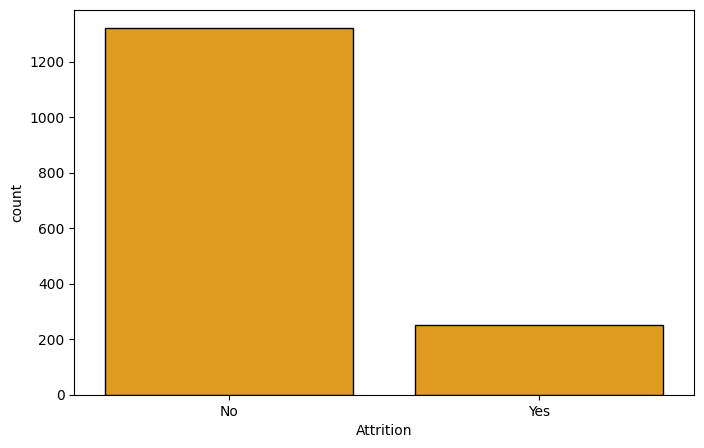

In [36]:
desbalanceo = slp.Desbalanceo(dataframe = df, variable_dependiente = "Attrition")
desbalanceo.visualizar_clase()

In [37]:
df['Attrition'].value_counts()

Attrition
0.0    1321
1.0     252
Name: count, dtype: int64

Vamos a aplicar el SMOTENC para solucionar el desbalanceo. Esto metodo hará upsumplig sobre la categoría minoritaria, la del "Yes", que pasada a numerica durante nuestro preprocesameinto es la que toma el valor 1.0

Tenemos algunas variables de tipo object (las categórcias). Vamos a meterlas en una lista ya que debemos pasarselas al SMOTENC como parámetro

In [38]:
df_cat=df.select_dtypes("O")
lista_categoricas=list(df_cat.columns)

In [39]:
lista_categoricas

['EnvironmentSatisfaction',
 'JobSatisfaction',
 'WorkLifeBalance',
 'BusinessTravel',
 'Department',
 'EducationField',
 'JobRole',
 'MaritalStatus',
 'TrainingTimesLastYear',
 'JobInvolvement',
 'Gender_Female',
 'Gender_Male',
 'Education_1.0',
 'Education_2.0',
 'Education_3.0',
 'Education_4.0',
 'Education_5.0',
 'JobLevel_Head',
 'JobLevel_Intern',
 'JobLevel_Junior',
 'JobLevel_Manager',
 'JobLevel_Senior',
 'StockOptionLevel_Bad',
 'StockOptionLevel_Best',
 'StockOptionLevel_Better',
 'StockOptionLevel_Good']

In [40]:
X = df.drop(columns = "Attrition")
y = df["Attrition"]
smotenc = SMOTENC(categorical_features=lista_categoricas, random_state=42, k_neighbors=5)
X_resampled, y_resampled = smotenc.fit_resample(X, y)
df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
df_resampled['Attrition'] = y_resampled 


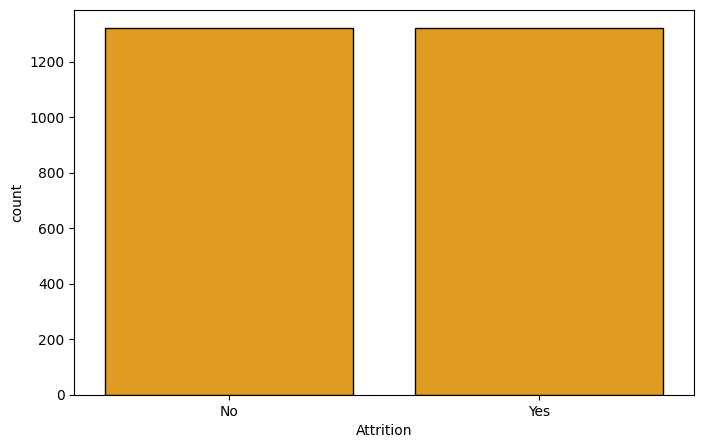

In [41]:
desbalanceo = slp.Desbalanceo(dataframe = df_resampled, variable_dependiente = "Attrition")
desbalanceo.visualizar_clase()

Ya no hay desbalanceo en la Variable Objetivo.

In [42]:
df_resampled.to_pickle("../../datos/modelo3/datos_preprocesados_y_desbalanceados.pkl")